# LPD Geometry

In this example, we will show you how to assemble the modules of the LPD detector into a single image.

In [1]:
import multiprocessing as mp
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from extra_data import RunDirectory, stack_detector_data
from pyfoamalgo.geometry import LPD_1MGeometry

mp.cpu_count()

80

In [2]:
run = RunDirectory("/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0007")

run.info()

# of trains:    507
Duration:       0:00:50.7
First train ID: 1487289920
Last train ID:  1487290426

13 detector modules (FXE_DET_LPD1M-1)
  e.g. module FXE_DET_LPD1M-1 0 : 256 x 256 pixels
  FXE_DET_LPD1M-1/DET/0CH0:xtdf
  30 frames per train, up to 15210 frames total

0 instrument sources (excluding detectors):

0 control sources: (1 entry per train)



In [3]:
_, train_data = run.train_from_index(0)

**By passing `real_array=False` in the function `stack_detector_data`, it actually returns an array-like wrapper around the existing arrays. Otherwise, the data will be copied which can be time-consuming.**

In [4]:
# Stack the detector modules into a single array.
modules_data = stack_detector_data(train_data, 'image.data', real_array=True)

modules_data.shape, modules_data.dtype

((30, 16, 256, 256), dtype('<f4'))

In [5]:
# Create the geometry with a geometry file and quadrant positions.
quad_pos = [(11.4, 299), (-11.5, 8), (254.5, -16), (278.5, 275)]  # mm
geom = LPD_1MGeometry.from_h5_file_and_quad_positions('lpd_mar_18_axesfixed.h5', quad_pos)

In [6]:
n_pulses = modules_data.shape[0]

# Allocate the assembled image array and reuse it as far as possible to speed up data processing.
assembled = geom.output_array_for_position_fast(extra_shape=(n_pulses,))
assembled.shape

(30, 1203, 1105)

In [7]:
t0 = time.perf_counter()

geom.position_all_modules(modules_data, out=assembled)

print(f"Assembling a train with {n_pulses} pulses takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

Assembling a train with 30 pulses takes: 8.8 ms


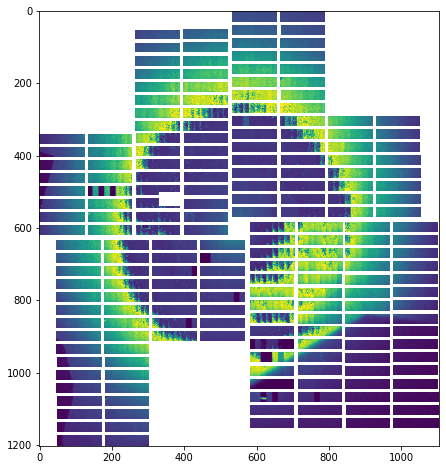

In [8]:
_, ax = plt.subplots(figsize=(8, 8))

ax.imshow(assembled[0], vmin=0, vmax=2500)